# Deep Neural Network for SMLM reconstruction with FRC loss

## 1) Configuration

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import os
import numpy as np

from matplotlib import pyplot as plt
from IPython import display

Limit GPU memory usage by Tensorflow:

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

Global parameters are location of training data, loss term and number of epochs.

In [3]:
PATH = 'data/'
LOSS = "ssim+frc+0.1*l1"
EPOCHS = 1000

----

## 2) Input data

Normalize images to [-1, 1] and mean zero:

In [4]:
def normalize(input_image, real_image):
    
  input_image = input_image - tf.reduce_min(input_image)
  real_image  = real_image  - tf.reduce_min(real_image)
    
  imax = tf.reduce_max(input_image)
  rmax = tf.reduce_max(real_image)
    
  input_image = (2.0 * input_image / imax) - 1.0
  real_image = (2.0 * real_image / rmax) - 1.0

  return input_image, real_image

Load function for images:

In [5]:
@tf.autograph.experimental.do_not_convert
def load_image(image_file):
    
    input_image = tf.io.read_file(image_file)
    input_image = tf.image.decode_png(input_image,dtype=tf.dtypes.uint16)

    real_image = tf.io.read_file(tf.strings.regex_replace(image_file, "sub.*", "full.png"))
    real_image = tf.image.decode_png(real_image,dtype=tf.dtypes.uint16)

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    
    im_stack = tf.stack((input_image, real_image))
    im_stack = tf.image.central_crop(im_stack, 0.8)
    im_stack = tf.image.random_crop(im_stack, size=(2, 750, 750, 1))
    input_image, real_image = tf.unstack(im_stack, 2)
    
    input_image, real_image = normalize(input_image, real_image)

    f1 = tf.random.uniform(shape=[], dtype=tf.float32)
    
    input_image = tfa.image.rotate(input_image, f1 * tf.constant(2.0 * np.pi))
    real_image  = tfa.image.rotate(real_image,  f1 * tf.constant(2.0 * np.pi))

    input_image = tf.image.crop_to_bounding_box(input_image, 119, 119, 512, 512)
    real_image  = tf.image.crop_to_bounding_box(real_image,  119, 119, 512, 512)

    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

Training dataset, using parallel loading to speed up training:

In [6]:
train_dataset = tf.data.Dataset.list_files(PATH + '/train/*sub*.png')
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(1)

Test dataset:

In [7]:
test_dataset = tf.data.Dataset.list_files(PATH + '/test/*sub*.png')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(1)

----

## 3) Define the model

We use the generator of the pix2pix U-Net adapted from https://www.tensorflow.org/tutorials/generative/pix2pix.

Downsampling step:

In [8]:
def downsample(filters, size, apply_batchnorm=True):

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', use_bias=False))
    
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

Upsampling step:

In [9]:
def upsample(filters, size, apply_dropout=False):

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

U-Net with downsampling, upsampling and skip connections:

In [10]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[512, 512, 1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  last = tf.keras.layers.Conv2DTranspose(1, 4,
                                         strides=2,
                                         padding='same',
                                         activation='tanh')  # (batch_size, 256, 256, 3)
    
  x = inputs
    
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

----

## 4) FRC loss

Pre-compute kernels for normalization:

In [11]:
from frc_loss import get_kernel_list

kernel_list = get_kernel_list(512)

FRC loss in Tensorflow:

In [12]:
@tf.function()
@tf.autograph.experimental.do_not_convert
def FRC_loss(i1, i2, kernel_list):

    i1 = tf.squeeze(i1, axis = 0)
    i1 = tf.squeeze(i1, axis = -1)
    
    i2 = tf.squeeze(i2, axis = 0)
    i2 = tf.squeeze(i2, axis = -1)

    i1 = tf.cast(i1, dtype = tf.complex64)
    i2 = tf.cast(i2, dtype = tf.complex64)
    
    I1 = tf.signal.fft2d(i1)   
    I2 = tf.signal.fft2d(i2)
    
    A = tf.multiply(I1, tf.math.conj(I2))
    B = tf.multiply(I1, tf.math.conj(I1))   
    C = tf.multiply(I2, tf.math.conj(I2))

    A_val = tf.reduce_mean(tf.multiply(A, kernel_list), axis=(1,2))
    B_val = tf.reduce_mean(tf.multiply(B, kernel_list), axis=(1,2))
    C_val = tf.reduce_mean(tf.multiply(C, kernel_list), axis=(1,2))
 
    den = tf.sqrt(tf.abs(tf.multiply(B_val,C_val)))
    
    res = tf.abs(A_val) / den
    
    return 1.0 - tf.reduce_sum(res[:100]) / 100.0

----

## 5) Configure Training

Define the different losses for training and monitoring, and evaluate loss term:

In [13]:
def generator_loss(gen_output, target):

    l1    = tf.reduce_mean(tf.square(gen_output-target))
    ssim  = tf.reduce_mean(1-tf.image.ssim_multiscale(gen_output, target, 2))   
    frc   = FRC_loss(gen_output*0.5+0.5,target*0.5+0.5,kernel_list)

    total_loss  =  eval(LOSS)

    return total_loss, l1, ssim, frc

Define optimizer:

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Create model instance:

In [15]:
generator = Generator()

Set checkpoint directory:

In [16]:
checkpoint_dir = './training_checkpoints/' + LOSS + "/"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,generator=generator)

Helper to generate intermediate images for monitoring:

In [17]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(17, 4))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input', 'Target', 'Output']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5,cmap=plt.get_cmap("pink"))
    plt.axis('off')
    plt.colorbar()
  plt.show()

Look at some test images:

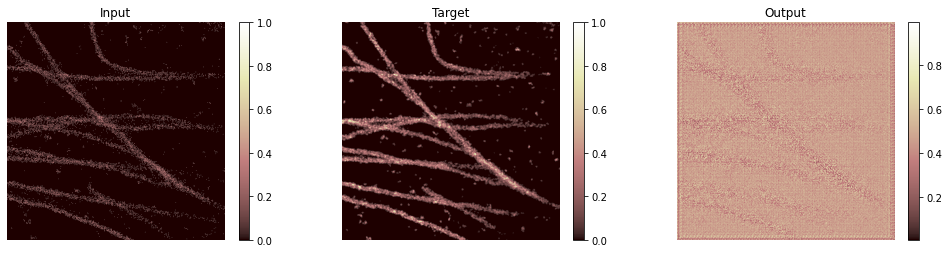

In [18]:
for example_input, example_target in train_dataset.take(1):
  generate_images(generator, example_input, example_target)

Setup log files for Tensorboard:

In [19]:
log_dir="logs/"
summary_writer = tf.summary.create_file_writer(log_dir + LOSS)

Train step to optimize model and write losses:

In [20]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape:
        gen_output = generator(input_image, training=True)

        total_loss, l1, ssim, frc = generator_loss(gen_output, target)

        generator_gradients = gen_tape.gradient(total_loss, generator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('total_loss', total_loss, step=epoch)
        tf.summary.scalar('L1', l1, step=epoch)
        tf.summary.scalar('MSSIM', ssim, step=epoch)
        tf.summary.scalar('FRC', frc, step=epoch)


Fit model, write validation loss and checkpoints:

In [21]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        
        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(1):
            
            generate_images(generator, example_input, example_target)
        
            gen_output = generator(example_input, training=True)
            
            total_loss, l1, ssim, frc = generator_loss(gen_output, example_target)
            
            with summary_writer.as_default():
                tf.summary.scalar('val_total_loss', total_loss, step=epoch)
                tf.summary.scalar('val_L1', l1, step=epoch)
                tf.summary.scalar('val_MSSIM', ssim, step=epoch)
                tf.summary.scalar('val_FRC', frc, step=epoch)

            print("Epoch: ", epoch)

        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
                        
        print()

        if (epoch + 1) % 1000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
    checkpoint.save(file_prefix=checkpoint_prefix)

In [22]:
%load_ext tensorboard

In [23]:
%tensorboard --logdir {log_dir}

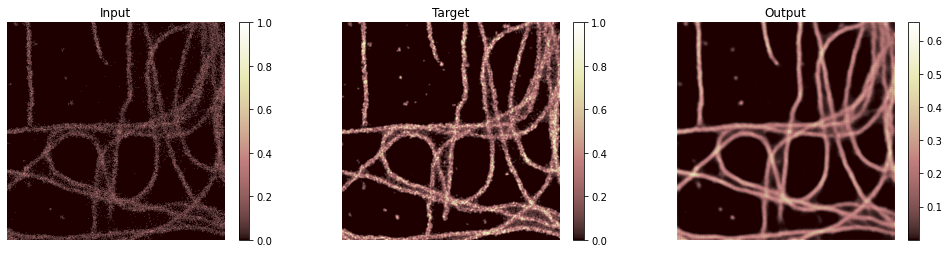

Epoch:  999
........


In [24]:
fit(train_dataset, EPOCHS, test_dataset)